In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt
import numpy as np

<Figure size 1500x1000 with 0 Axes>

In [3]:
pca_per_pathway = pd.read_csv('../data/pca_per_pathway.csv', index_col=0)

new_clinical_patient = pd.read_csv('../data/data_clinical_patient.txt', sep='\t', index_col=0).iloc[4:]
new_clinical_sample = pd.read_csv('../data/data_clinical_sample.txt', sep='\t', index_col=0).iloc[4:]
new_clinical = pd.concat([new_clinical_patient, new_clinical_sample.reindex(new_clinical_patient.index)], axis=1)
new_clinical['Triple Neg'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Negative')) else False, axis = 1)

new_clinical['ER-/PR-/HER2+'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Positive')) else False, axis = 1)


full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)

In [7]:
from scipy.stats import ttest_ind, mannwhitneyu
import qvalue as qv

clusterframes = {}

grouped_by_cluster = full_df.groupby('Integrative Cluster')

for group in grouped_by_cluster:
    df_cluster = pd.DataFrame(index=full_df.iloc[:,:-33].columns)
    groupname = group[0]
    df = group[1].iloc[:,:-33]
    group2_df = full_df[full_df['Integrative Cluster'] != groupname].iloc[:,:-33]
    pvaluelist = []
    group1_mean_list = []
    group2_mean_list = []
    for pathway in df:
        group = df[pathway]
        group2 = group2_df[pathway]
        test = mannwhitneyu(group, group2, alternative='two-sided')
        pvaluelist.append(test[1])
        group_mean = group.mean()
        group1_mean_list.append(group_mean)
        group2_mean = group2.mean()
        group2_mean_list.append(group2_mean) 
        
    
    df_cluster[f'Cluster {groupname}'] = group1_mean_list
    df_cluster['Other clusters'] = group2_mean_list
    df_cluster['Fold Change'] = np.log2(abs(df_cluster[f'Cluster {groupname}'])) - np.log2(abs(df_cluster['Other clusters']))
    
    
    df_cluster['p-values'] = pvaluelist
    qv.qvalues(df_cluster, 'p-values', f'cluster {groupname} qvalues')
    #df_cluster['p-values'] = -np.log10(df_cluster['p-values'])
    #df_cluster[f'cluster {groupname} qvalues'] = -np.log10(df_cluster[f'cluster {groupname} qvalues'])
    print(groupname)
    clusterframes[groupname] = df_cluster
        
        

1
10
2
3
4ER+
4ER-
5
6
7
8
9


In [8]:
from statistics import mean, median
listofnums = clusterframes['1']['p-values'].tolist()
print(type(listofnums[0]))
print(mean(listofnums))
print(median(listofnums))

<class 'float'>
0.18463082984096213
0.010000452800129418


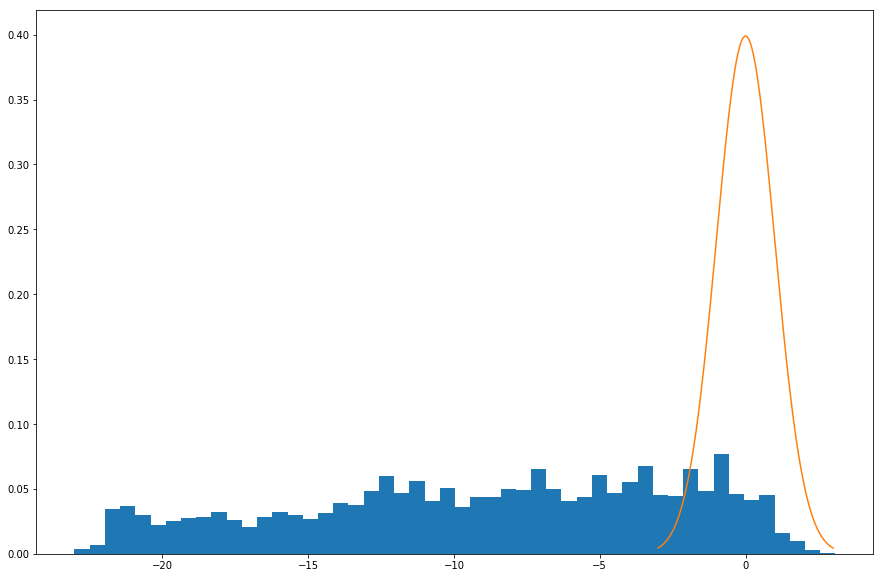

In [9]:
from scipy.stats import norm
def null_testing_cluster(cluster):
    ##Generate Zscores
    p_vals= clusterframes[cluster][f'p-values'].tolist()
    p_significance = norm.ppf(p_vals)
    
    ## Plot distribution of pathway eigenvalues
    plt.figure(figsize=(15, 10))
    plt.hist(p_significance, bins=50, density=True)

    ##Null distribution
    mu, sigma = 0, 1
    x = np.linspace(mu -3 *sigma, mu + 3*sigma, 1000)
    plt.plot(x, norm.pdf(x, 0, 1))
    #plt.savefig(f'cluster_{cluster}_p_distribution.png')
    plt.show()
    
null_testing_cluster('10')


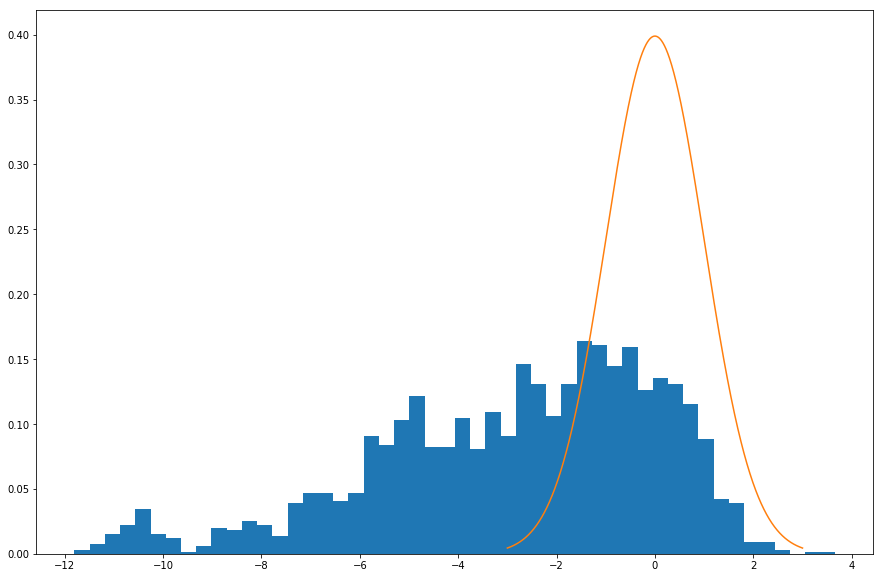

In [10]:
null_testing_cluster('1')

[0.1110258  0.12934721 0.14766862 0.16599003 0.18431144 0.20263285
 0.22095426 0.23927567 0.25759708 0.27591849 0.2942399  0.31256131
 0.33088272 0.34920413 0.36752554 0.38584695 0.40416836 0.42248977
 0.44081118 0.45913259 0.477454   0.49577541 0.51409682 0.53241823
 0.55073964 0.56906105 0.58738246 0.60570387 0.62402528 0.64234669
 0.6606681  0.67898951 0.69731092 0.71563233 0.73395374 0.75227515
 0.77059656 0.78891797 0.80723938 0.82556079 0.8438822  0.86220361
 0.88052502 0.89884643 0.91716784 0.93548925 0.95381066 0.97213207
 0.99045348 1.00877489 1.0270963  1.04541771 1.06373912 1.08206053
 1.10038194 1.11870335 1.13702476 1.15534617 1.17366758 1.19198899
 1.2103104  1.22863181 1.24695322 1.26527463 1.28359604 1.30191745
 1.32023886 1.33856027 1.35688168 1.37520309 1.3935245  1.41184591
 1.43016732 1.44848873 1.46681014 1.48513155 1.50345296 1.52177436
 1.54009577 1.55841718 1.57673859 1.59506    1.61338141 1.63170282
 1.65002423 1.66834564 1.68666705 1.70498846 1.72330987 1.7416

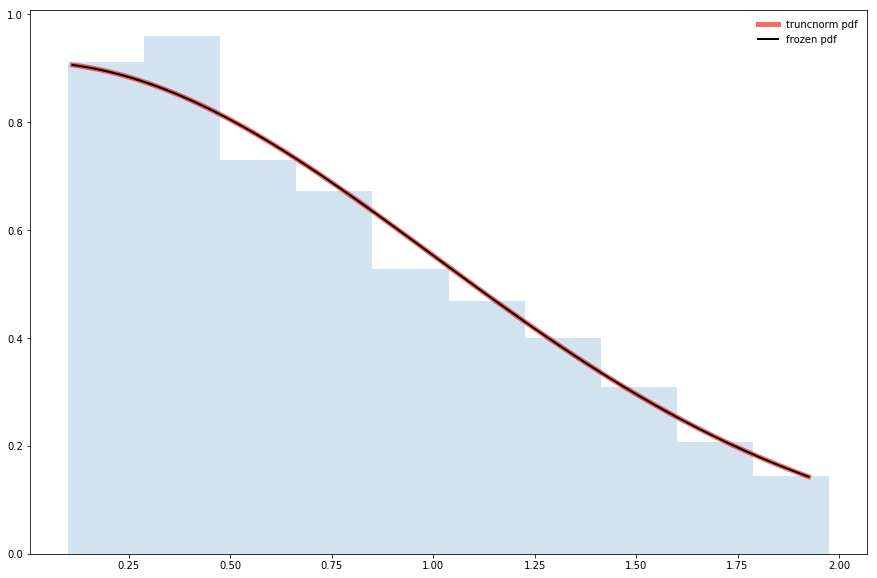

In [46]:
from scipy.stats import truncnorm
fig, ax = plt.subplots(1, 1, figsize=(15,10))
a, b = 0.1, 2
mean, var, skew, kurt = truncnorm.stats(a, b, moments='mvsk')
x = np.linspace(truncnorm.ppf(0.01, a, b), truncnorm.ppf(0.99, a, b), 100)
print(x)
ax.plot(x, truncnorm.pdf(x, a, b), 'r-', lw=5, alpha=0.6, label = 'truncnorm pdf')

rv = truncnorm(a, b)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

vals = truncnorm.ppf([0.001, 0.5, 0.999], a, b)
np.allclose([0.001, 0.5, 0.999], truncnorm.cdf(vals, a, b))

r= truncnorm.rvs(a, b, size=1000)
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

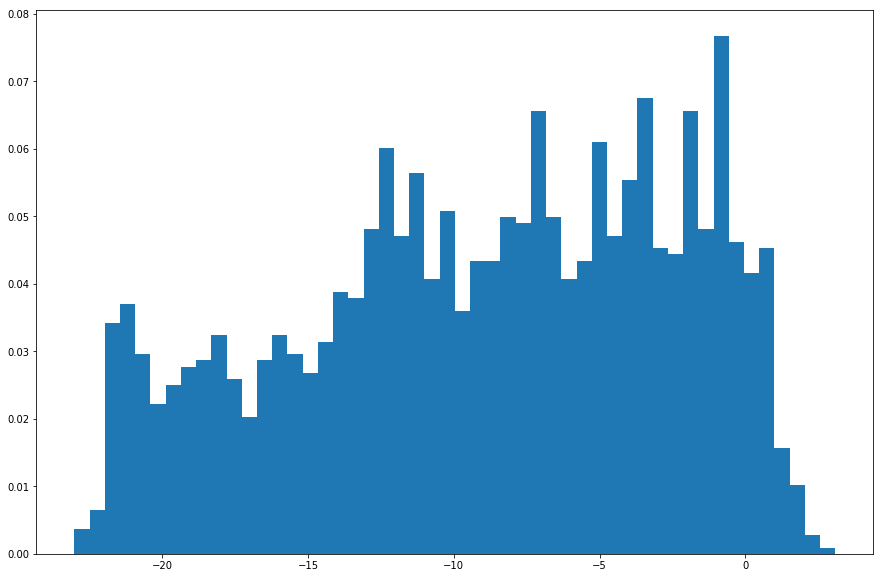

-23.014110679296266
3.0817311784889427
-8.950402823019154
6.471171072801809
[-23.01411068 -22.76075812 -22.58660468 ...   2.26649269   2.36698458
   3.08173118]
[0. 0. 0. ... 0. 0. 0.]


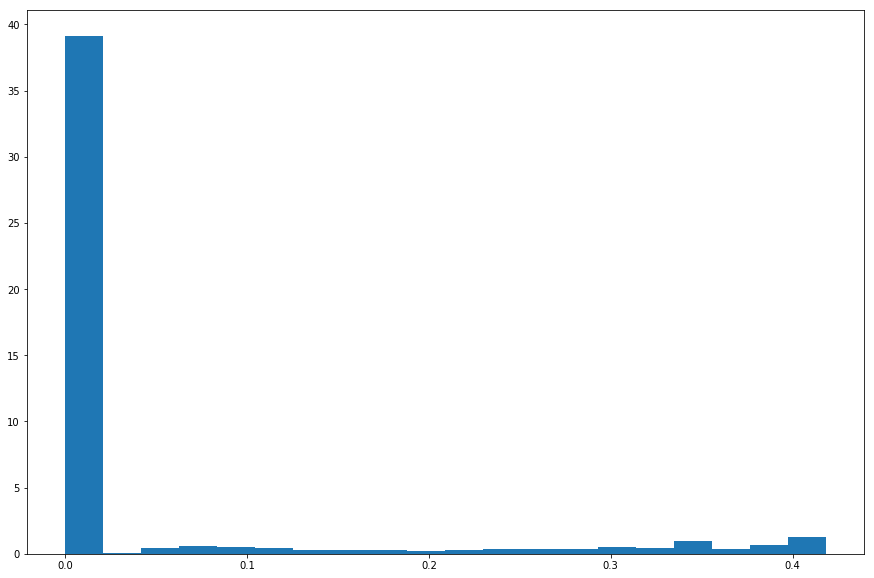

In [12]:
from scipy.stats import truncnorm

def make_pdf(cluster):
    pvalues = clusterframes[cluster][f'p-values'].tolist()
    zvalues = norm.ppf(pvalues)
    plt.figure(figsize=(15, 10))
    plt.hist(zvalues, bins=50, density=True)
    plt.show()
    print(min(zvalues))
    print(max(zvalues))
    print(np.mean(zvalues))
    print(np.std(zvalues))
    print(zvalues)
    a = (min(zvalues) - np.mean(zvalues))/(np.std(zvalues))
    b = (max(zvalues) - np.mean(zvalues))/(np.std(zvalues))
    #a = min(zvalues)
    #b = max(zvalues)
    pdf_ = truncnorm.pdf(zvalues, a, b)
    print(pdf_)
    plt.figure(figsize=(15,10))
    plt.hist(pdf_, bins=20, density=True)
    plt.show()
    
make_pdf('10')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4037.578357675575
            Iterations: 15
            Function evaluations: 98
            Gradient evaluations: 15
[-4.70794507  2.20816845 -1.49098504  1.80737346]
<class 'numpy.ndarray'>


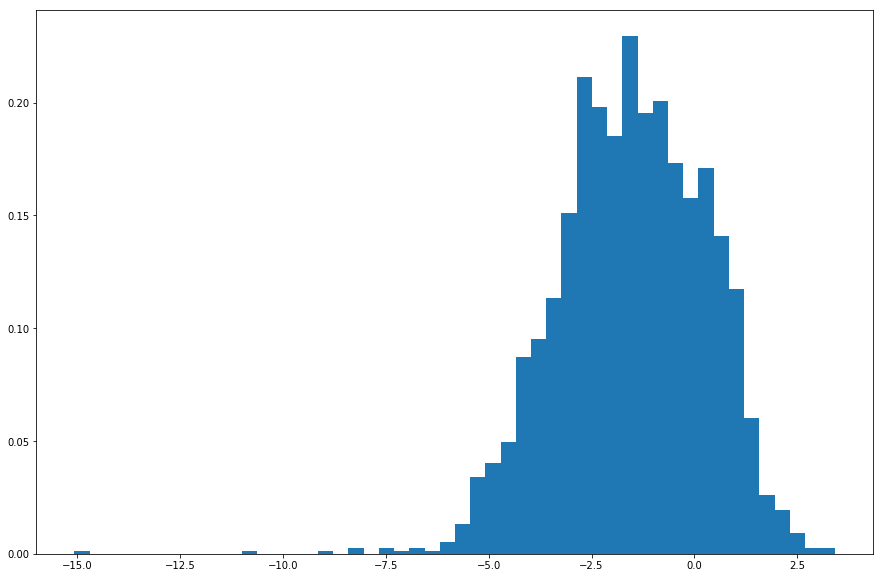

[-15.06419428 -10.66452283  -8.85067259 ...   2.99239375   3.06828921
   3.42486315]


TypeError: _parse_args() takes from 1 to 3 positional arguments but 5 were given

In [59]:
from scipy.stats import truncnorm, norm
from scipy.optimize import fmin_slsqp
import matplotlib.pyplot as plt


pvalues = clusterframes['6']['p-values'].tolist()
z_scores = norm.ppf(pvalues)

xa = -10
xb = 2.5

trunc_z = z_scores[z_scores>xa]
trunc_z = trunc_z[trunc_z<xb]

def func(p, r, xa, xb):
    return truncnorm.nnlf(p, r)

def constraint(p, r, xa, xb):
    a, b, loc, scale = p
    return np.array([a*scale + loc - xa, b*scale + loc - xb])

loc = 0
scale = 1

a = (xa - loc)/scale
b = (xb - loc)/scale

loc_guess = 0
scale_guess = 1
a_guess = (xa - loc_guess)/scale_guess
b_guess = (xb - loc_guess)/scale_guess
p0 = [a_guess, b_guess, loc_guess, scale_guess]

par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(trunc_z, xa, xb), iter=10000)
print(par)
print(type(par))

plt.figure(figsize=(15, 10))
plt.hist(z_scores, bins=50, density=True)
plt.show()

print(z_scores)
pdf_ = norm.pdf(z_scores, par[0], par[1], par[2], par[3])


plt.figure(figsize=(15, 10))
plt.hist(pdf_, bins=50)
plt.savefig('cluster_pdf.png')
plt.show()


-2.800515680697193 2.893380347885639


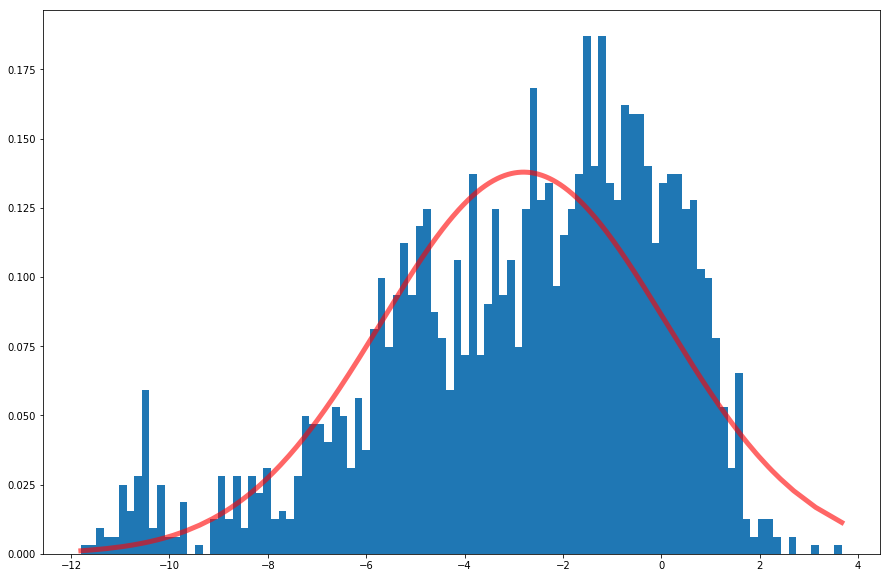

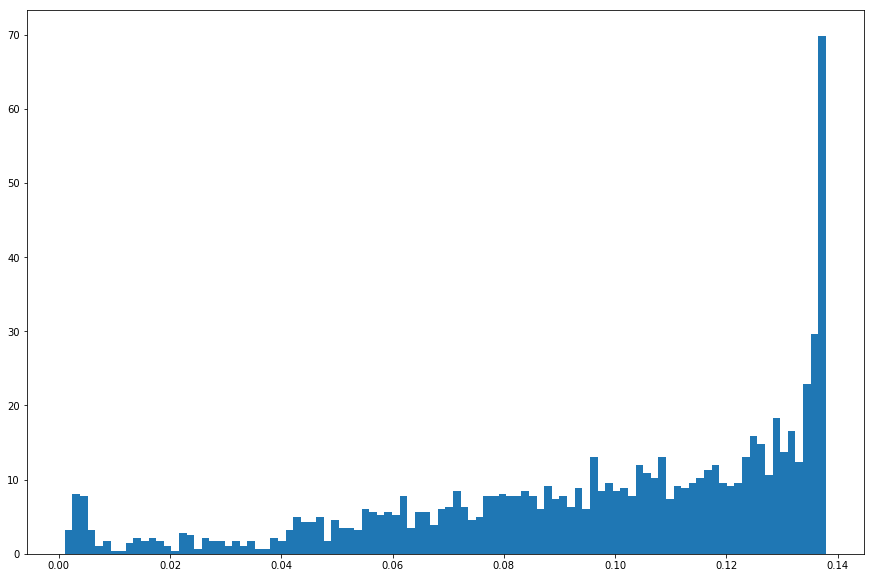

[0.001094   0.0013996  0.00166333 0.00170448 0.00170448 0.00184057
 0.00191246 0.0023051  0.00235247 0.00256249 0.00260977 0.00267932
 0.00268352 0.00277182 0.00277347 0.00277347 0.00281368 0.00289179
 0.00297135 0.00307662 0.0031675  0.00326498 0.00326878 0.00336116
 0.00337677 0.00340966 0.00363891 0.0036935  0.00372106 0.00372798
 0.00374131 0.00379723 0.00383145 0.00383745 0.00384073 0.00384346
 0.00387749 0.00389349 0.00391566 0.0039755  0.00399185 0.00399185
 0.00399185 0.00402018 0.0040384  0.00423227 0.00428242 0.00428242
 0.00428242 0.00429503 0.00468471 0.00471525 0.00488726 0.00507428
 0.00540779 0.0054644  0.00550217 0.00551481 0.00552226 0.00562892
 0.00563953 0.00577668 0.00604576 0.00667656 0.00743099 0.00752514
 0.00793386 0.00799865 0.00816151 0.00831241 0.00835865 0.01035754
 0.01255136 0.0132498  0.01337554 0.01340019 0.01388794 0.01405999
 0.01408882 0.0141579  0.01461583 0.01477157 0.01482655 0.01482822
 0.01507171 0.01550224 0.01591402 0.01662931 0.01673714 0.0172

In [149]:
pvalues = clusterframes['1']['p-values'].tolist()
z_scores = norm.ppf(pvalues)

'''
xa = -8
xb = 2

trunc_z = z_scores[z_scores>xa]
trunc_z = trunc_z[trunc_z<xb]

def func(p, r, xa, xb):
    return truncnorm.nnlf(p, r)

def constraint(p, r, xa, xb):
    a, b, loc, scale = p
    return np.array([a*scale + loc - xa, b*scale + loc - xb])

loc = 0
scale = 1

a = (xa - loc)/scale
b = (xb - loc)/scale

loc_guess = 0
scale_guess = 1
a_guess = (xa - loc_guess)/scale_guess
b_guess = (xb - loc_guess)/scale_guess
p0 = [a_guess, b_guess, loc_guess, scale_guess]

par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(trunc_z, xa, xb), iter=10000)
print(par)
'''

mean, var = norm.fit(z_scores)
print(mean, var)



fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.hist(z_scores, bins=100, density=True)
ax.plot(z_scores, norm.pdf(z_scores, mean, var), 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()


normal_Z = norm.pdf(z_scores, mean, var)
plt.figure(figsize=(15, 10))
plt.hist(normal_Z, bins=100, density=True)
plt.show()
print(normal_Z)
normal_p = norm.sf(-abs(normal_Z))
#print(normal_p)

#how are the p-values ordered?



print(f'{(normal_p <= 0.001).sum()} pathways have p <= 0.001')